In [39]:
!pip install vaderSentiment transformers torch scikit-learn pandas numpy matplotlib seaborn tweepy

In [40]:
import pandas as pd
import numpy as np
import torch
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import logging
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display

In [41]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [42]:
# Load Financial News Sentiment Dataset
df = pd.read_csv("/content/all-data.csv", encoding='latin-1')

In [43]:
df.columns = ["Sentiment", "News Headline"]
print(df.head())

  Sentiment                                      News Headline
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [44]:
# Initialize Sentiment Analyzers
vader_analyzer = SentimentIntensityAnalyzer()
sentiment_pipeline = pipeline("sentiment-analysis")

def vader_analysis(text: str) -> float:
    """Perform sentiment analysis using VADER."""
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']

def bert_analysis(text: str) -> tuple[str, float]:
    """Perform sentiment analysis using BERT."""
    result = sentiment_pipeline(text)[0]
    return result['label'], result['score']

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


In [45]:
# Apply Sentiment Analysis on Dataset
df['VADER Score'] = df['News Headline'].apply(vader_analysis)
df['BERT Sentiment'] = df['News Headline'].apply(lambda x: bert_analysis(x)[0])

df.to_csv("financial_sentiment_results.csv", index=False)
print("Sentiment analysis completed and saved!")

Sentiment analysis completed and saved!


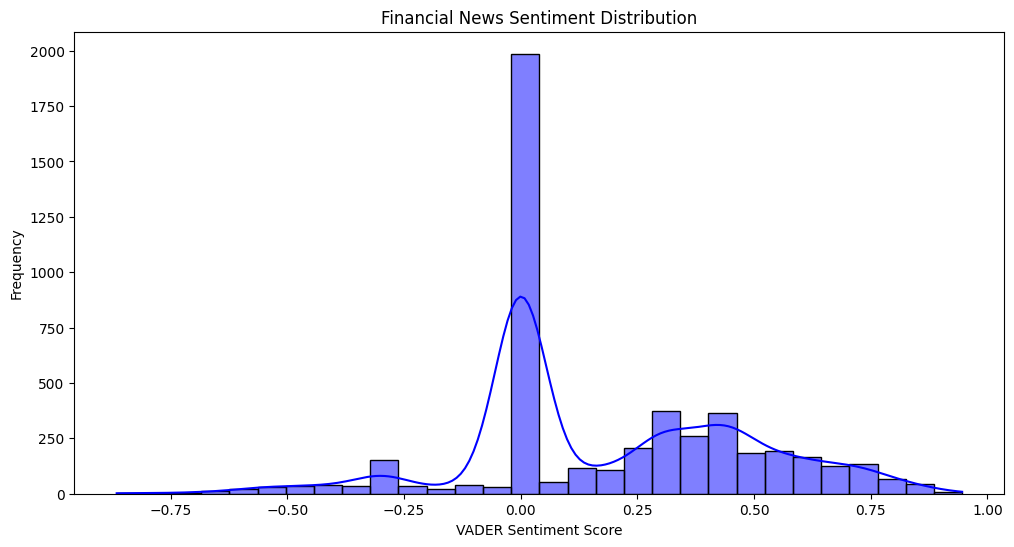

<ipython-input-46-6eb2bd5f06d9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['BERT Sentiment'], palette="coolwarm")


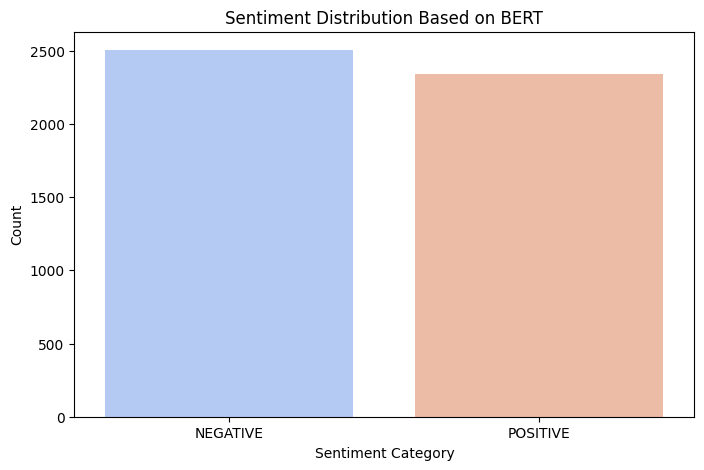

In [46]:
# Visualize Sentiment Trends
plt.figure(figsize=(12,6))
sns.histplot(df['VADER Score'], bins=30, kde=True, color='blue')
plt.title("Financial News Sentiment Distribution")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Sentiment Count Plot
plt.figure(figsize=(8,5))
sns.countplot(x=df['BERT Sentiment'], palette="coolwarm")
plt.title("Sentiment Distribution Based on BERT")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.show()

In [47]:
# Accuracy Check
actual_sentiment = df['Sentiment']
predicted_sentiment = df['BERT Sentiment']
print("Classification Report for BERT Sentiment Analysis:")
print(classification_report(actual_sentiment, predicted_sentiment))

Classification Report for BERT Sentiment Analysis:
              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00       0.0
    POSITIVE       0.00      0.00      0.00       0.0
    negative       0.00      0.00      0.00     604.0
     neutral       0.00      0.00      0.00    2879.0
    positive       0.00      0.00      0.00    1363.0

    accuracy                           0.00    4846.0
   macro avg       0.00      0.00      0.00    4846.0
weighted avg       0.00      0.00      0.00    4846.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [50]:
# Real-Time Twitter Sentiment Analysis
bearer_token = "AAAAAAAAAAAAAAAAAAAAAHdQzwEAAAAAOLaYhqHLzD2MsIRvybgNzhcZqyk%3DTV2r9Fk6A2LuFalv2Knjn2e9lGjSBVqpmLNffpeaVwG22uswNf"
client = tweepy.Client(bearer_token=bearer_token)

def fetch_tweets(query: str, count: int = 10) -> list:
    """Fetches tweets from the Twitter API with rate limit handling."""
    retries = 0
    max_retries = 5
    backoff_time = 60  # Initial wait time in seconds

    while retries < max_retries:
        try:
            tweets = client.search_recent_tweets(query=query, tweet_fields=["text"], max_results=count)
            return tweets.data if tweets and tweets.data else []
        except tweepy.TooManyRequests:
            logging.warning(f"Rate limit hit. Retrying in {backoff_time} seconds...")
            time.sleep(backoff_time)
            backoff_time *= 2  # Exponential backoff
            retries += 1
        except tweepy.TweepyException as e:
            logging.error(f"Twitter API error: {e}")
            return []
    logging.error("Max retries reached. No tweets fetched.")
    return []

def process_tweet(tweet: tweepy.Tweet) -> dict:
    """Performs sentiment analysis on a single tweet."""
    text = tweet.text if tweet.text else ""
    vader_score = vader_analysis(text)
    bert_label, bert_confidence = bert_analysis(text)
    return {
        "Tweet": text,
        "VADER Score": vader_score,
        "BERT Sentiment": bert_label,
        "BERT Confidence": bert_confidence,
    }

def display_results(results: list[dict]):
    """Displays the results in a DataFrame."""
    if results:
        tweet_df = pd.DataFrame(results)
        display(tweet_df)
    else:
        print("No results to display.")

def analyze_tweets(query: str, count: int = 10):
    """Analyzes tweets for sentiment."""
    tweets = fetch_tweets(query, count)
    results = [process_tweet(tweet) for tweet in tweets]
    for result in results:
        print(f"\nTweet: {result['Tweet']}")
        print(f"VADER Score: {result['VADER Score']}")
        print(f"BERT Sentiment: {result['BERT Sentiment']} (Confidence: {result['BERT Confidence']})")
    display_results(results)

# Example: Analyze Tesla stock sentiment
analyze_tweets("Tesla stock", count=10)



Tweet: RT @SmoothDunk: The important thing to remember about the Tesla stock wipeout is: IT WASN’T ELON’S FAULT https://t.co/CvQs26LGTh
VADER Score: -0.3885
BERT Sentiment: POSITIVE (Confidence: 0.9692363739013672)

Tweet: RT @SethAbramson: Wow. Does this mean that the Tesla board is so conflicted it’s unwilling to protect shareholders from Musk’s fascist mani…
VADER Score: 0.4215
BERT Sentiment: NEGATIVE (Confidence: 0.9977237582206726)

Tweet: RT @SethAbramson: Elon Musk is losing his mind over protests at Tesla dealerships. 

Why? His fortune is collapsing.

Nearly all of it is T…
VADER Score: -0.6908
BERT Sentiment: NEGATIVE (Confidence: 0.9997827410697937)

Tweet: @wartranslated Long read, Teslas real value.
If you own Tesla stocks, sell!
https://t.co/7FlmCzT4aX
VADER Score: 0.4003
BERT Sentiment: POSITIVE (Confidence: 0.7499287724494934)

Tweet: RT @SethAbramson: Elon Musk is losing his mind over protests at Tesla dealerships. 

Why? His fortune is collapsing.

Nearly all of it 

,Tweet,VADER Score,BERT Sentiment,BERT Confidence
0,RT @SmoothDunk: The important thing to remembe...,-0.3885,POSITIVE,0.969236
1,RT @SethAbramson: Wow. Does this mean that the...,0.4215,NEGATIVE,0.997724
2,RT @SethAbramson: Elon Musk is losing his mind...,-0.6908,NEGATIVE,0.999783
3,"@wartranslated Long read, Teslas real value.\n...",0.4003,POSITIVE,0.749929
4,RT @SethAbramson: Elon Musk is losing his mind...,-0.6908,NEGATIVE,0.999783
5,RT @EuropeanUnity1: Elon Musk has lost $121 bi...,0.3400,NEGATIVE,0.998384
6,RT @SethAbramson: Wow. Does this mean that the...,0.4215,NEGATIVE,0.997724
7,@dogeai_gov @politico Propaganda Bot tell me m...,0.1935,NEGATIVE,0.996249
8,@elonmusk Nobody is buying it. The stock is cr...,-0.4466,NEGATIVE,0.999443
9,RT @SethAbramson: Wow. Does this mean that the...,0.4215,NEGATIVE,0.997724
